# CNN - sponsorship model

Consider senate number 115, this notebook aims to predict votes profile for a bill using the sponsors' votes information.

Any other information on each senator can be encoded on a similarity graph.

In [231]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload

from lib import models_alt, graph, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
VOTES_PATH = '../data/votes/votes_{}.csv'
BILLS_PATH = '../data/bills/bills_{}.csv'
SEED = 123

In [144]:
def numeric_votes(x):
    if x == 'Yes':
        return 1
    elif x == 'Not Voting' or pd.isnull(x):
        return 0 # we can put np.nan and then fill with the median or mean, whatever for now
    else:
        return -1

In [145]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 200
params['batch_size']     = 10
params['eval_frequency'] = 40

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['p']              = [1, 1]  
params['K']              = [4, 4]
         
# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 1
params['decay_rate']     = 0.95
params['momentum']       = 0

In [147]:
def load_data(congress_nb):
    all_bills = pd.read_csv(BILLS_PATH.format(congress_nb))
    votes = pd.read_csv(VOTES_PATH.format(congress_nb))
    bills_sen = all_bills[all_bills.sponsor_title=='Sen.'] # bills sponsored by senators
    members_aux = pd.DataFrame(list(votes['member_id'].unique())).rename(columns={0: 'member_id'})
    members = members_aux.merge(votes.drop_duplicates(subset = 'member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
    
    N_BILLS_SEN = bills_sen.shape[0]    
    N_SENATORS = len(members)
    
    votes_matrix=np.zeros((len(votes.vote_uri.unique()), N_SENATORS))

    for i, l in enumerate(list(votes.vote_uri.unique())):
        votes_aux = (members.merge(votes[votes.vote_uri == l], how='left'))
        feature = votes_aux.vote_position.apply(numeric_votes).values
        votes_matrix[i] = feature
        
    for i,j in enumerate(bills_sen.cosponsors_sen):
        bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)
        
    return bills_sen, members, votes, votes_matrix

def get_train_test_data(bills_sen, members, votes):
    N_BILLS_SEN = bills_sen.shape[0]    
    N_SENATORS = len(members)
    
    CS = np.zeros((N_BILLS_SEN, N_SENATORS))
    S = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1
        for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
            CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1
            
    Z = S + CS # sponsorship mask
    
    Y=np.zeros((N_BILLS_SEN, N_SENATORS))

    for i, l in enumerate(list(bills_sen.vote_uri)):
        votes_aux = (members.merge(votes[votes.vote_uri == l], how='left'))
        feature = votes_aux.vote_position.apply(numeric_votes).values
        Y[i] = feature

    X = np.zeros((N_BILLS_SEN, N_SENATORS))
    X[Z==1]=Y[Z==1]
    
    n = X.shape[0]
    d = X.shape[1]

    n_train = n//2
    n_val = n//10
    
    perm_idx = np.random.permutation(n)
    X_train = X[perm_idx[:n_train]]
    X_val = X[perm_idx[n_train:n_train+n_val]]
    X_test = X[perm_idx[n_train+n_val:]]

    y_train = Y[perm_idx[:n_train]]
    y_val = Y[perm_idx[n_train:n_train+n_val]]
    y_test = Y[perm_idx[n_train+n_val:]]

    return X_train, X_val, X_test, y_train, y_val, y_test

def get_graph(votes_matrix):
    dist, idx = graph.distance_scipy_spatial(votes_matrix.T, k=20, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    L = [graph.laplacian(A, normalized=True) for i in range(2)]
    return A, L

def set_params(X_train, learning_rate, params):
    params['learning_rate']  = learning_rate
    params['decay_steps']    = X_train.shape[0] / params['batch_size']
    params['M']              = [X_train.shape[1]]    
    return params


def run_CNN(L, params, X_train, y_train, X_val, y_val):
    model = models_alt.cgcnn(L, **params)
    loss_train, loss_val, train_accs, val_accs, t_step = model.fit(X_train, y_train, X_val, y_val, False)
    
    return loss_train, loss_val, train_accs, val_accs, model

def eval_prediction(Pred):
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

def accuracy(pred, truth):
    not_vot = np.not_equal(truth, 0)
    a = np.equal(pred, truth)
    acc=np.sum(a[not_vot])/np.size(truth[not_vot])
    return acc

def predict_train_test(X_train, X_test):
    Pred_train = model.predict(X_train)
    Pred_test = model.predict(X_test)
    Pred_train = eval_prediction(Pred_train)
    Pred_test = eval_prediction(Pred_test)

    return Pred_train, Pred_test

def rel_err(truth, preds):
    valid_indices = np.where(np.any([truth==1, truth==-1], axis=0))
    return np.linalg.norm(truth[valid_indices] - preds[valid_indices], 2) / np.linalg.norm(truth, 2)

def compute_acc(truth, preds):
    valid_indices = np.where(np.any([truth==1, truth==-1], axis=0))
    return (truth[valid_indices] == preds[valid_indices]).sum(axis = 0) / len(valid_indices)

def compute_prediction_err_acc(Truth, Pred):
    err_v = []
    acc_v = []
    
    for i in range(Truth.shape[0]):
        acc_v.append(compute_acc(Truth[i], Pred[i]))
        err_v.append(rel_err(Truth[i], Pred[i]))
        
    return err_v, acc_v

In [180]:
np.random.seed(SEED)

Acc_tr = []
Acc_te = []
Err_tr = []
Err_te = []

for congress_nb in range(105, 116):
    if congress_nb != 106:
        bills_sen, members, votes, votes_matrix = load_data(congress_nb)
        X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_data(bills_sen, members, votes)
        A, L = get_graph(votes_matrix)
        params = set_params(X_train, 0.1, params)
        loss_train, loss_val, train_accs, val_accs, model = run_CNN(L, params, X_train, y_train, X_val, y_val)

        Pred_train, Pred_test = predict_train_test(X_train, X_test)

        err_tr, acc_tr = compute_prediction_err_acc(y_train, Pred_train)
        err_te, acc_te = compute_prediction_err_acc(y_test, Pred_test)

        Err_tr.append(err_tr)
        Err_te.append(err_te)
        Acc_tr.append(acc_tr)
        Acc_te.append(acc_te)
    

INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-580
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-580
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-400
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-400
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-480
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-480
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-3260
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-3260
INFO:tensorflo

STD

In [230]:
pd.DataFrame([pd.DataFrame(Acc_tr).std(axis = 1), pd.DataFrame(Err_tr).std(axis=1), pd.DataFrame(Acc_te).std(axis=1), pd.DataFrame(Err_te).std(axis=1)], index = ['Acc_tr', 'Err_tr','Acc_te', 'Err_te'])

,0,1,2,3,4,5,6,7,8,9
Acc_tr,17.630094,4.669047,11.492909,16.413478,17.560028,20.320873,16.527274,11.243224,22.497047,7.365895
Err_tr,0.533987,0.256648,0.425219,0.462222,0.481586,0.556035,0.484451,0.393542,0.580647,0.304586
Acc_te,17.402394,20.135272,15.580943,21.063955,18.667015,19.594037,17.958122,17.964357,20.685923,23.034970
Err_te,0.378765,0.435901,0.280183,0.453970,0.419420,0.404826,0.382342,0.404037,0.509316,0.562750


Mean

In [228]:
pd.DataFrame([pd.DataFrame(Acc_tr).mean(axis = 1), pd.DataFrame(Err_tr).mean(axis=1), pd.DataFrame(Acc_te).mean(axis=1), pd.DataFrame(Err_te).mean(axis=1)], index = ['Acc_tr', 'Err_tr','Acc_te', 'Err_te'])

,0,1,2,3,4,5,6,7,8,9
Acc_tr,86.965517,94.700000,88.500000,84.846626,81.768116,77.628205,84.816794,91.270833,81.992248,94.512821
Err_tr,0.418274,0.209303,0.372817,0.562527,0.564087,0.669447,0.547434,0.321489,0.533944,0.231275
Acc_te,62.480000,69.687500,58.850000,76.045802,73.044643,77.761905,72.209524,78.217949,79.769231,80.878788
Err_te,1.148540,0.969522,1.208455,0.831837,0.883964,0.760210,0.945362,0.792585,0.686258,0.631378


In [243]:
cong_vec = [i for i in range(105, 116) if i != 106]

In [339]:
c=0
df=pd.DataFrame()
for i in range(105, 116):
    if i != 106:
        df = df.append(pd.DataFrame(data=[Err_tr[c], Acc_tr[c], Err_te[c], Acc_te[c], [i for j in range(len(Err_tr[c]))]]).transpose())
        c+=1
df.columns = ['Err_tr', 'Acc_tr', 'Err_te', 'Acc_te', 'Congress']

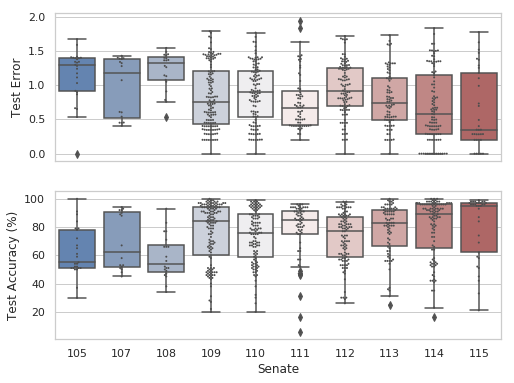

In [375]:
fig, ax= plt.subplots(2,1, figsize=(8,6))
sns.set(style="whitegrid")
sns.boxplot(x='Congress',y='Err_te', data=df, palette="vlag", ax=ax[0])
sns.swarmplot(x='Congress',y='Err_te', data=df, size=2, color=".3", ax=ax[0])
sns.boxplot(x='Congress',y='Acc_te', data=df, palette="vlag", ax=ax[1])
sns.swarmplot(x='Congress',y='Acc_te', data=df, size=2, color=".3", ax=ax[1])
ax[0].set_ylabel('Test Error')
ax[1].set_ylabel('Test Accuracy (%)')
ax[0].set_xticks([])
ax[0].set_xlabel('')

plt.xlabel('Senate')
plt.xticks(np.arange(10),[i for i in range(105,116) if i !=106]);
plt.savefig('figs/test_err_cnn.pdf')

### Congress 115

In [204]:
bills_sen, members, votes, votes_matrix = load_data(115)
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_data(bills_sen, members, votes)
A, L = get_graph(votes_matrix)
params = set_params(X_train, 0.1, params)
loss_train, loss_val, train_accs, val_accs, model = run_CNN(L, params, X_train, y_train, X_val, y_val)

Pred_train, Pred_test = predict_train_test(X_train, X_test)



INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-780
INFO:tensorflow:Restoring parameters from /Users/virginiabordignon/US-Senators/notebooks/lib/../checkpoints/demo/model-780


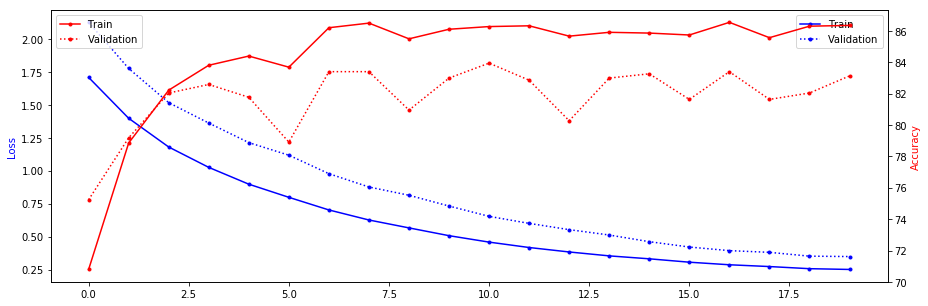

In [205]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(loss_train, 'b.-')
ax1.set_ylabel('Loss', color='b')
ax1.plot(loss_val, 'b.:')
ax1.legend(['Train', 'Validation'])
ax2 = ax1.twinx()
ax2.plot(train_accs, 'r.-')
ax2.set_ylabel('Accuracy', color='r')
ax2.plot(val_accs, 'r.:')
ax2.legend(['Train', 'Validation'])

plt.show()

In [115]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['blue','white','red'])


Text(0.5, 1.0, 'Training truth')

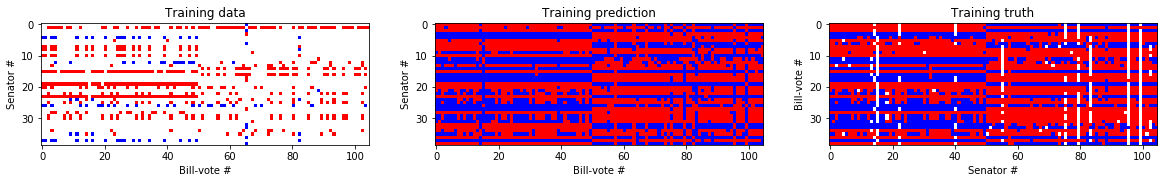

In [206]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Bill-vote #')
plt.ylabel('Senator #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth')

In [207]:
print('Accuracy train: ', accuracy(Pred_train,y_train))

Accuracy train:  0.9239613274105043


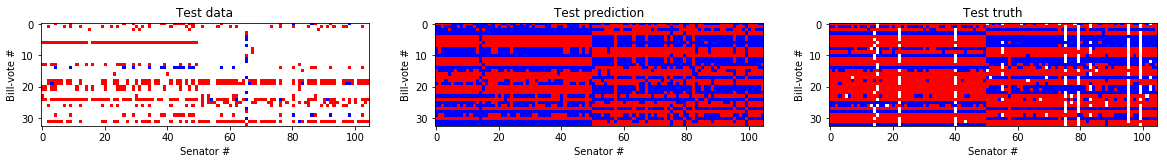

In [208]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth');

In [209]:
print('Accuracy test: ', accuracy(Pred_test,y_test))

Accuracy test:  0.8367221195317314


In [26]:
# l_rate_vec = np.linspace(1e-2, 0.9, 20)
# VAL_ACC = np.zeros(len(l_rate_vec))
# for i, k in enumerate(poly_vec):
#     for j, l in enumerate(l_rate_vec):
#         params['K'] = [k, k]
#         params['learning_rate']  = l 
#         model = models_alt.cgcnn(L, **params)
#         loss_train, loss_val, train_accs, val_accs, t_step = model.fit(X_train_, y_train_, X_val_, y_val_, False)
#         VAL_ACC[i,j] = val_accs[-1]
        

In [27]:
val_acc_array = np.array(VAL_ACC)

In [28]:
ind_max = np.unravel_index(np.argmax(val_acc_array, axis=None), val_acc_array.shape)

In [37]:
print('Max validation accuracy: {:.2f} for a poly degree {:.2f} and a learning rate {:.2f}'.format(val_acc_array[ind_max], poly_vec[ind_max[0]], l_rate_vec[ind_max[0]]))

Max validation accuracy: 83.29 for a poly degree 2.00 and a learning rate 0.06
